## Общая информация о проекте

**Описание проекта:**
Нужно разобраться, как ведут себя пользователи  мобильного приложения стартапа, который занимается продажейт продуктов питания. 
****
**Цели проекта:**
- Изучить воронку продаж. 
- Узнать, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
- Исследовать результаты A/A/B-эксперимента по внедрению нового шрифта в приложение. 

**План работы:**

- Загрузка данных и предобработка:
    - Загрузка библиотек и данных
    - Просмотр общей информации 
    - Изменение названий столбцов
    - Проверка на дубликаты и пропуски
    - Работа с датами
    - Проверка на попадание пользователей в несколько групп
    - Вывод
    
- Изучение и проверка данных:
    - Сколько всего событий в логе?
    - Сколько всего пользователей в логе?
    - Сколько в среднем событий приходится на пользователя?
    - Данные за какой период имеются? 
    - Проверка, что есть пользователи из всех трёх экспериментальных групп.
    - Вывод
- Изучение воронки событий:
    - Какие события есть в логах, как часто они встречаются.
    - Cколько пользователей совершали каждое из этих событий и в каком порядке
    - Какая доля пользователей проходит на следующий шаг воронки.
    - Какая доля пользователей доходит от первого события до оплаты? 
    - Вывод
- Изучение результатов эксперимента:
    - Сколько пользователей в каждой экспериментальной группе?
    - Находят ли статистические критерии разницу между выборками 246 и 247.
    - Число  и доля пользователей, совершивших самое популярное событие в каждой из контрольных групп.
    - Число  и доля пользователей, совершивших другие события в каждой из контрольных групп.
    - Число  и доля пользователей, совершивших самое популярное событие в группе  с измененным шрифтом.
    - Число  и доля пользователей, совершивших другие события в группе  с измененным шрифтом.
    - Число и доля пользователей, совершивших события в группе с измененным шрифтом и обеими контрольными группами сразу.
    - Вывод
- Выводы

**Описание данных:**

Каждая запись в логе — это действие пользователя, или событие. 

- event_name — название события;
- device_id  — уникальный идентификатор пользователя;
- event_timestamp — время события;
- exp_id — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.
- event_time - дата и время события
- date - дата события

## Загрузка данных и предобработка

### Загрузка библиотек и данных

In [50]:
#импортируем нужные библиотеки
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from scipy import stats as st
import math as mth
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [51]:
#грузим наши данные для работы
logs = pd.read_csv('/datasets/logs_exp.csv', sep= '\t')

### Просмотр общей информации

In [52]:
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [53]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Изменение названий столбцов

In [54]:
logs = logs.rename(columns = {'EventName':'event_name', \
                              'DeviceIDHash':'device_id', \
                              'EventTimestamp':'event_timestamp', \
                              'ExpId':'exp_id'
                             })

In [55]:
logs.head()

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


### Проверка на дубликаты и пропуски

In [56]:
logs.shape

(244126, 4)

In [57]:
# проверка на явные дубликаты
print(f'Дубликатов обнаружено:{logs.duplicated().sum()}')

Дубликатов обнаружено:413


In [58]:
#убираем дубликаты
logs = logs.drop_duplicates().reset_index(drop=True)

,event_name,device_id,event_timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,1565212345,247
243709,MainScreenAppear,5849806612437486590,1565212439,246
243710,MainScreenAppear,5746969938801999050,1565212483,246
243711,MainScreenAppear,5746969938801999050,1565212498,246


In [59]:
# проверяем на пропуски
logs.isna().sum().sort_values()

event_name         0
device_id          0
event_timestamp    0
exp_id             0
dtype: int64

Было обнаружено 413 дубликатов, их мы удалили. Пропусков в данных нет.

### Работа с датами

In [60]:
#создадим столбец с датой и временем события
logs['event_time'] = logs['event_timestamp'].astype('datetime64[s]')

In [61]:
#создадим столбец с отдельной датой
logs['date'] = logs['event_time'].dt.date

In [62]:
#удалим столбец event_timestamp, так как он нам больше не понадобится
logs.drop(columns = 'event_timestamp')

,event_name,device_id,exp_id,event_time,date
0,MainScreenAppear,4575588528974610257,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,247,2019-08-07 21:12:25,2019-08-07
244122,MainScreenAppear,5849806612437486590,246,2019-08-07 21:13:59,2019-08-07
244123,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:43,2019-08-07
244124,MainScreenAppear,5746969938801999050,246,2019-08-07 21:14:58,2019-08-07


### Проверка на попадание пользователей в несколько групп

In [63]:
two_groups = logs.groupby('device_id').agg({'exp_id':'nunique'})
two_groups = two_groups.query('exp_id > 1')

print(f'Пользователей, попавших в несколько групп:',two_groups['exp_id'].count())

Пользователей, попавших в несколько групп: 0


У нас нет пользователей, которые бы по ошибке попали в несколько групп.

### Вывод

 У нас есть данные, содержащие информацию о произошедших в мобильном приложении событиях.
 
 - Формат названий столбцов был приведен к более удобному в работе формату;
 - В данных были обнаружены 413 дубликатов, их мы устранили;
 - В данных не обнаружено пропусков;
 - Пользователи распределены по гоуппам верно, нет пользователей, попавших в несколько групп;
 - Данные были обогащены столбцом с датой и временем событий и столбцом с датами событий. Ненужный нам более столбец event_timestamp мы убрали.
 

## Изучение и проверка данных:
   

- Сколько всего событий в логе?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Данные за какой период имеются? 
- Проверка, что есть пользователи из всех трёх экспериментальных групп.
- Вывод

### Сколько всего событий в логе?

In [64]:
events_sum = logs.groupby('event_name')['device_id'].count() \
                 .sort_values(ascending = False) \
                 .reset_index()
events_sum.columns = ['event', 'sum_users']

events_sum

,event,sum_users
0,MainScreenAppear,119205
1,OffersScreenAppear,46825
2,CartScreenAppear,42731
3,PaymentScreenSuccessful,34313
4,Tutorial,1052


Видим, что у нас 5 типов событий  и по количеству лидирует показ главной страницы. А самое непопулярное событие - это прохождение обучения.

### Сколько всего пользователей в логе?

In [65]:
users_sum = logs.groupby('device_id')['event_name'].count() \
                .sort_values(ascending = False) \
                .reset_index()
users_sum.columns = ['device_id', 'sum_events']

users_sum

,device_id,sum_events
0,6304868067479728361,2308
1,197027893265565660,2003
2,4623191541214045580,1771
3,6932517045703054087,1448
4,1754140665440434215,1222
...,...,...
7546,395376432319166724,1
7547,7340109038762980814,1
7548,4890736107619881150,1
7549,2284191870135457477,1


У нас данные по 7551 пользователю. Некоторые совершили довольно много действий( макисмум 2307), но часть юзеров ограничилась только одним действием.

### Сколько в среднем событий приходится на пользователя?

Среднее число событий на пользователя: 32.33
Медианное число событий на пользователя 20.0


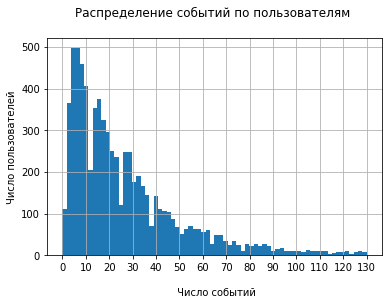

In [66]:
logs.groupby('device_id')['event_name'].count().hist(range=(0,130), bins=70)

plt.title('Распределение событий по пользователям \n')
plt.locator_params(axis='x', nbins=20)
plt.xlabel('\n Число событий')
plt.ylabel('Число пользователей');

print(f'Среднее число событий на пользователя:', round((logs.groupby('device_id')['event_name'].count()).mean(),2))
print(f'Медианное число событий на пользователя', logs.groupby('device_id')['event_name'].count().median())

Как мы видим, в среднем на каждого юзера приходится по 32 действия. Медианное значение при этом ниже, всего 20, значит существуют пользователи с аномально большим количеством действий (как мы видели ранее, есть юзеры с количеством действий около 1000-2000)

###  Данные за какой период имеются?

In [67]:
print(f'Минимальная дата в наших данных :', logs['date'].min())
print(f'Максимальная дата в наших данных :', logs['date'].max())
print(f'Мы располагаем сведениями за', (logs['date'].max() - logs['date'].min()).days, 'дней' )

Минимальная дата в наших данных : 2019-07-25
Максимальная дата в наших данных : 2019-08-07
Мы располагаем сведениями за 13 дней


Построим гисторамму по датам:

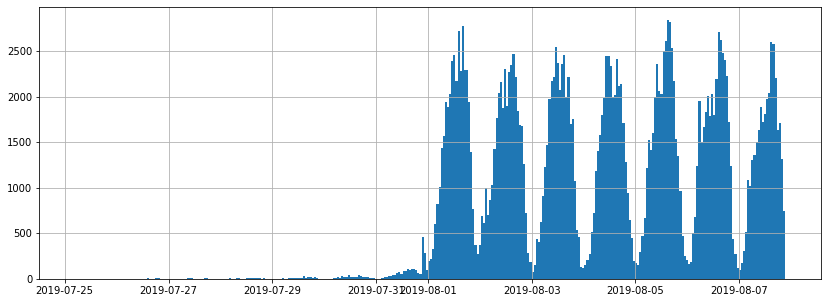

In [69]:
logs['event_time'].hist(bins=14*24, figsize=(14, 5));

Судя по графику, полные данные за день у нас начинаются только с 1 августа. Уберем из наших данных неполные сведения:

In [70]:
logs_new = logs[logs['event_time'] >= '2019-08-01 00:00:00']
logs_new.head()

,event_name,device_id,event_timestamp,exp_id,event_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [71]:
print( f'Было отброшено всего', logs.shape[0]- logs_new.shape[0], 'событий')
print(f'Что составило', round((((logs.shape[0]- logs_new.shape[0]) / logs.shape[0])* 100),2), 'процента от всего количества событий' )
print( f'Пользователей было отброшено', logs.device_id.nunique() - logs_new.device_id.nunique(),'шт.')
print( f'Что составило', round((((logs.device_id.nunique() - logs_new.device_id.nunique()) /logs.device_id.nunique())* 100),2),'процента от всего количества пользователей')
print(f'Теперь мы располагаем сведениями за', (logs_new['date'].max() - logs_new['date'].min()).days, 'дней' )

Было отброшено всего 2828 событий
Что составило 1.16 процента от всего количества событий
Пользователей было отброшено 17 шт.
Что составило 0.23 процента от всего количества пользователей
Теперь мы располагаем сведениями за 6 дней


### Проверка, что есть пользователи из всех трёх экспериментальных групп

In [72]:
logs.groupby('exp_id')['device_id'].nunique()

exp_id
246    2489
247    2520
248    2542
Name: device_id, dtype: int64

In [73]:
logs_new.groupby('exp_id')['device_id'].nunique()

exp_id
246    2484
247    2513
248    2537
Name: device_id, dtype: int64

Как мы видим, остались пользователи из всех трёх групп, изменения в соотношениях незначительные

### Вывод

- В наших данных 5 типов событий и по количеству лидирует показ главной страницы. А самое непопулярное событие- это прохождение обучения;
-  у нас данные по 7551 пользователю. Некоторые совершили довольно много действий (макисмум 2307), но часть юзеров ограничилась только одним действием. В среднем каждый пользователь совершает по 32 действия, но медиана событий 20, лучше ориентироваться на нее, так как среднее пострадало из-за "выбросов"- пользователей с очень большим количеством событий;
- Изначально у нас имеются сведения за 13 дней(с 25 июля 2019 по 7 августа 2019 года). Однако, данные за некоторые дни являются неполными и было принято решение их отбросить. На данный момент мы располагаем сведениями за 6 дней (с 1 августа 2019 по 7 августа 2019 года). В новом датасете есть пользователи из всех трёх групп. Было отброшено 2826 событий (что составило 1,16% от общего числа событий) и 17 пользователей (что составляет 0.23% от общего количества пользователей).


## Изучение воронки событий



- Какие события есть в логах, как часто они встречаются. 
- Cколько пользователей совершали каждое из этих событий и в каком порядке
- Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). 
- На каком шаге теряется больше всего пользователей?
- Какая доля пользователей доходит от первого события до оплаты? 
- Вывод

### Какие события есть в логах, как часто они встречаются

Посмотрим, какие события есть в логах и как часто они встречаются:

In [74]:
events_sum_new = logs_new.groupby('event_name')['device_id'].count() \
                 .sort_values(ascending = False) \
                 .reset_index()
events_sum_new.columns = ['event', 'sum_users']

events_sum_new

,event,sum_users
0,MainScreenAppear,117431
1,OffersScreenAppear,46350
2,CartScreenAppear,42365
3,PaymentScreenSuccessful,34113
4,Tutorial,1039


Как и в изначальном датасете самое частое событие- это показ главное экрана, а самое непопулярное- обучение

###  Cколько пользователей совершали каждое из этих событий и в каком порядке

Посчитаем, сколько пользователей совершали каждое из этих событий и посчитаем долю пользователей, которые хоть раз совершали событие:

In [75]:
events_users = logs_new.groupby('event_name')['device_id'].nunique() \
                       .sort_values(ascending=False) \
                       .reset_index()

events_users.columns = ['event', 'count_users']

events_users['percent_of_all_users']= round(events_users['count_users']/logs_new['device_id'].nunique()*100,2)
events_users

,event,count_users,percent_of_all_users
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Как мы видим не все пользователи начали действия с просмотра гавного экрана, вероятно, это те пользователи, что перешли по рекламному баннеру сразу к товару(OffersScreenAppear) и не стали переходить на главный экран.  

Судя по процентному соотношению, порядок взаимодействия с приложением следующий: 

    сначала демонстрация главного экрана (MainScreenAppear), затем показ страницы товара (OffersScreenAppear), далее переход в корзину (CartScreenAppear) и оплата (PaymentScreenSuccessful).

Шаг с обучением логичнее всего должен происходит в начале итерации (так как нет смысла обучать тех, кто уже разобрался со всей схемой работы),но может в теорит проходить на любом этапе, да и обучение проходят всего 11.15 % пользователей, возможно оно не так уж и нужно нашему приложению, либо нуждается в переработке. Принимаем решение, отказаться от шага "Tutorial" в дальнейшем исследовании

### Какая доля пользователей проходит на следующий шаг воронки

In [76]:
#убираем события вида Tutorial
events_users = events_users.query('event != "Tutorial"')

#добавляем столбец с конверсией от предыдущего шага
events_users['conversion'] = round(((events_users['count_users'].pct_change() * 100) + 100),1)

print( f'Всего', events_users['conversion'][1] ,'% пользователей, увидевших главную страницу, переходят на страницу товара.')  
print( f'Всего', events_users['conversion'][2] ,'% пользователей, смотревших страницу товара, переходят в корзину.')  
print( f'Всего', events_users['conversion'][3] ,'% пользователей, смотревших корзину, оплачивают заказ.')  

Всего 61.9 % пользователей, увидевших главную страницу, переходят на страницу товара.
Всего 81.3 % пользователей, смотревших страницу товара, переходят в корзину.
Всего 94.8 % пользователей, смотревших корзину, оплачивают заказ.


Больше всего пользователей теряется на втором шаге, 38.1 % пользователей увидевших главный экран не перешли к просмотру товара.

### Какая доля пользователей доходит от первого события до оплаты?

In [77]:
events_users['first_to_last'] = round((events_users['count_users'] / events_users['count_users'][0]) * 100,1)
events_users

,event,count_users,percent_of_all_users,conversion,first_to_last
0,MainScreenAppear,7419,98.47,NaN,100.0
1,OffersScreenAppear,4593,60.96,61.9,61.9
2,CartScreenAppear,3734,49.56,81.3,50.3
3,PaymentScreenSuccessful,3539,46.97,94.8,47.7


Как мы видим, весь путь от первого до последнего этапа проходят 47.7 % пользователей.

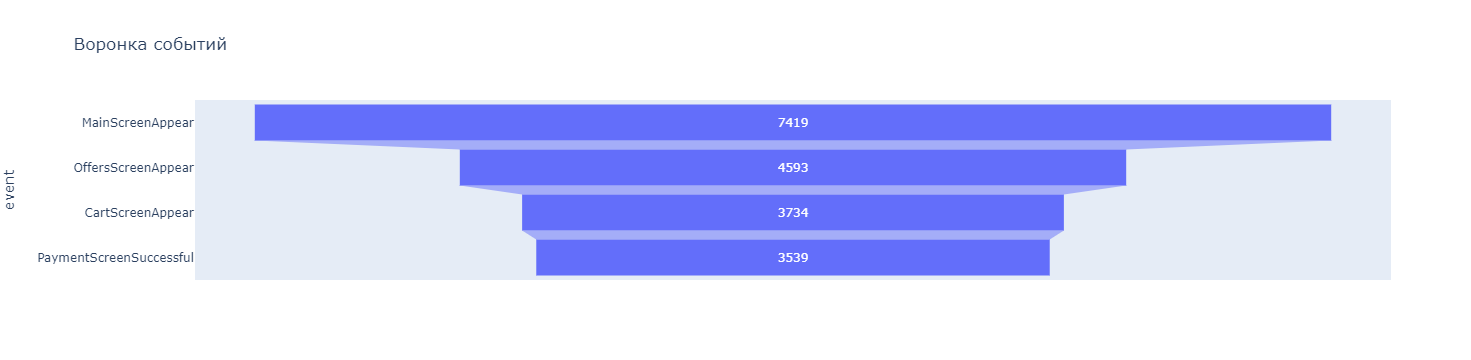

In [78]:
#визуализируем воронку
fig = px.funnel(events_users, y='event', x='count_users',title='Воронка событий')
fig.show()

### Вывод

- В нашем приложении сложился следующий порядок событий:  Просмотр главного экрана- переход к странице товара- переход в корзину- оплата; 
- Событие типа"обучение(tutorial)" проходят только 11.15 % пользователей и оно может быть пройдено на любом этапе и было принято решение исключить его из исследования;
- 98.47% проходят через событие просмотра главного экрана, оставшийся 1.53 % вероятно попадает сразу на страницу товара через рекламу или ссылку; 
- Самые большие потери пользователей (38.1%) происходят на втором этапе, при переходе от главного экрана к странице товара;
- Меньше всего потерь (5.2%) при переходе из корзины к оплате. Вероятно на этом этапе люди ужеточно определяются с покупкой.
- Весь путь от первого до последнего этапа проходят 47.7 % пользователей.


## Изучение результатов эксперимента:
    


246 и 247 — контрольные группы, а 248 — экспериментальная.

- Сколько пользователей в каждой экспериментальной группе?
- Находят ли статистические критерии разницу между выборками 246 и 247.
- Число и доля пользователей, совершивших самое популярное событие в каждой из контрольных групп.
- Число и доля пользователей, совершивших другие события в каждой из контрольных групп.
- Число и доля пользователей, совершивших самое популярное событие в группе с измененным шрифтом.
- Число и доля пользователей, совершивших другие события в группе с измененным шрифтом.
- Число и доля пользователей, совершивших события в группе с измененным шрифтом и обеими контрольными группами сразу.
- Вывод

### Сколько пользователей в каждой экспериментальной группе?
   

Cоздадим таблицу с количеством пользователей по группам, убрав событие "Tutorials" из исследования:

In [79]:
logs_new = logs_new.query('event_name != "Tutorial"')

In [80]:
sum_users_groups = logs_new.pivot_table(index=['exp_id'], values='device_id', aggfunc={'nunique'}) \
                           .reset_index()
sum_users_groups.columns = ['group', 'sum_users']
sum_users_groups

,group,sum_users
0,246,2483
1,247,2512
2,248,2535


### Находят ли статистические критерии разницу между выборками 246 и 247.


Создадим таблицу, содержащую сведения о событиях и количествах пользователей для каждой из групп и добавим сведения о том, сколько пользователей в обеих контрольных группах:

In [81]:
groups=logs_new.pivot_table(index=['event_name'], columns='exp_id', values='device_id', aggfunc={'nunique'}) \
               .reset_index()
groups.columns = ['event', '246','247', '248']
groups['246_plus_247'] = groups['246'] + groups['247']
groups

,event,246,247,248,246_plus_247
0,CartScreenAppear,1266,1238,1230,2504
1,MainScreenAppear,2450,2476,2493,4926
2,OffersScreenAppear,1542,1520,1531,3062
3,PaymentScreenSuccessful,1200,1158,1181,2358


Напишем формулу для расчета z-критерия, используя также поправку Бонферрони для множественных сравнений, чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез:

In [82]:
def stat_diff (successes1, successes2, trials1, trials2):
    
    alpha = 0.05
    
    # пропорция успехов в первой группе:
    
    p1 = successes1/trials1
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2 
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # разница пропорций в датасетах
    difference = p1 - p2  
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    #применим поправку Бонферрони. У нас 4 теста, по 4 сравнения
    bonferroni_alpha = alpha / 16
 
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )        

### Число и доля пользователей, совершивших самое популярное событие в каждой из контрольных групп.

Возьмём самое популярное событие во всех группах, а именно показ главного экрана (MainScreenAppear) и проверим следующие гипотезы о равенстве долей в контрольных группах 246 и 247:

H_0:  Доли пользователей, совершивших самое популярное событие в обеих контрольных группах одинаковые.

H_а:  Доли пользователей, совершивших самое популярное событие в обеих контрольных группах разные.


In [83]:
print(groups.iloc[1].iloc[0])

stat_diff(groups.iloc[1]['246'],
          groups.iloc[1]['247'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[1]['sum_users'],
        )  

MainScreenAppear
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Число и доля пользователей, совершивших другие события в каждой из контрольных групп.

Проверим следующие гипотезы о равенстве долей в контрольных группах 246 и 247 относительно остальных событий:

H_0: Доли пользователей, совершивших  событие в обеих контрольных группах одинаковые.

H_а: Доли пользователей, совершивших  событие в обеих контрольных группах разные.

In [84]:
print(groups.iloc[2].iloc[0])

stat_diff(groups.iloc[2]['246'],
          groups.iloc[2]['247'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[1]['sum_users'],
        )  

OffersScreenAppear
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [85]:
print(groups.iloc[0].iloc[0])

stat_diff(groups.iloc[0]['246'],
          groups.iloc[0]['247'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[1]['sum_users'],
         )  

CartScreenAppear
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [86]:
print(groups.iloc[3].iloc[0])

stat_diff(groups.iloc[3]['246'],
          groups.iloc[3]['247'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[1]['sum_users'],
        )  

PaymentScreenSuccessful
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Во всех случаях нулевая гипотеза не была отвергнута,значит есть основания полагать, что распрелеление в контрольных группах нормальное.

### Число и доля пользователей, совершивших самое популярное событие в группе с измененным шрифтом.

Теперь также возьмём самое популярное событие во всех группах, а именно показ главного экрана (MainScreenAppear) и проверим следующие гипотезы о равенстве долей  в группах 246/248 и 247/248:

H_0: Доли пользователей, совершивших самое популярное событие в обеих группах одинаковые.

H_а: Доли пользователей, совершивших самое популярное событие в обеих группах разные.


Сначала посмотрим с группами 246 и 248

In [87]:
print(groups.iloc[1].iloc[0],246)

stat_diff(groups.iloc[1]['246'],
          groups.iloc[1]['248'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         )  

MainScreenAppear 246
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


А теперь с группами 247 и 248

In [88]:
print(groups.iloc[1].iloc[0],247)

stat_diff(groups.iloc[1]['247'],
          groups.iloc[1]['248'],
          sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         )  

MainScreenAppear 247
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Число и доля пользователей, совершивших другие события в группе с измененным шрифтом.

Проверим следующие гипотезы о равенстве долей в  группах 246/248 и 247/248 относительно остальных событий:

H_0: Доли пользователей, совершивших  событие в обеих группах одинаковые.

H_а: Доли пользователей, совершивших  событие в обеих группах разные.

In [89]:
print(groups.iloc[2].iloc[0],246)

stat_diff(groups.iloc[2]['246'],
          groups.iloc[2]['248'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
        )  
         
print('*******')

print(groups.iloc[2].iloc[0],247)

stat_diff(groups.iloc[2]['247'],
          groups.iloc[2]['248'],
          sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
        ) 

OffersScreenAppear 246
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
*******
OffersScreenAppear 247
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [90]:
print(groups.iloc[0].iloc[0],246)

stat_diff(groups.iloc[0]['246'],
          groups.iloc[0]['248'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         )  
         
print('*******')

print(groups.iloc[0].iloc[0], 247)

stat_diff(groups.iloc[0]['247'],
          groups.iloc[0]['248'],
          sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         )  

CartScreenAppear 246
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
*******
CartScreenAppear 247
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [91]:
print(groups.iloc[3].iloc[0],246)

stat_diff(groups.iloc[3]['246'],
          groups.iloc[3]['248'],
          sum_users_groups.iloc[0]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
        )  
print('*******')

print(groups.iloc[3].iloc[0],247)

stat_diff(groups.iloc[3]['247'],
          groups.iloc[3]['248'],
          sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
        ) 

PaymentScreenSuccessful 246
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
*******
PaymentScreenSuccessful 247
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Число и доля пользователей, совершивших все варианты события в группе с измененным шрифтом и двух контрольных группах вместе

Проверим следующие гипотезы о равенстве долей в  группах 246 + 247  и 248 относительно всех вариантов событий:

H_0: Доли пользователей, совершивших  событие в группах одинаковые.

H_а: Доли пользователей, совершивших  событие в  группах разные.

In [92]:
print(groups.iloc[1].iloc[0],'246 и 247 вместе')

stat_diff(groups.iloc[1]['246_plus_247'],
          groups.iloc[1]['248'],
          sum_users_groups.iloc[0]['sum_users'] + sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         ) 

MainScreenAppear 246 и 247 вместе
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [93]:
print(groups.iloc[2].iloc[0],'246 и 247 вместе')

stat_diff(groups.iloc[2]['246_plus_247'],
          groups.iloc[2]['248'],
          sum_users_groups.iloc[0]['sum_users'] + sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         ) 

OffersScreenAppear 246 и 247 вместе
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [94]:
print(groups.iloc[0].iloc[0],'246 и 247 вместе')

stat_diff(groups.iloc[0]['246_plus_247'],
          groups.iloc[0]['248'],
          sum_users_groups.iloc[0]['sum_users'] + sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         ) 

CartScreenAppear 246 и 247 вместе
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


In [95]:
print(groups.iloc[3].iloc[0],'246 и 247 вместе')

stat_diff(groups.iloc[3]['246_plus_247'],
          groups.iloc[3]['248'],
          sum_users_groups.iloc[0]['sum_users'] + sum_users_groups.iloc[1]['sum_users'],
          sum_users_groups.iloc[2]['sum_users'],
         ) 

PaymentScreenSuccessful 246 и 247 вместе
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


### Вывод

- У нас имеется 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, мы проверили, находят ли статистические критерии разницу между выборками 246 и 247 и выяснили, что разницы между выборками критерии не обнаружили на всех видах событий.

- Мы проверили также находят ли статистические критерии разницу между контрольными и тестовой группой и выяснили, что на всех видах событий также не обнаружилось разницы, а значит пользователям нашего приложения всё равно какой шрифт мы используем( новый или старый).

- Для избегания ошибок множественных сравнений мы использовали поправку Бонферрони,так как она легче всего рассчитыввется, без сбора новых наблюдений для каждого теста.


## Выводы

- Формат названий столбцов был приведен к более удобному в работе формату. В данных были обнаружены 413 дубликатов, их мы устранилию, не обнаружено пропусков. Пользователи распределены по группам верно, нет пользователей, попавших в несколько групп. Данные были обогащены столбцом с датой и временем событий и столбцом с датами событий.


- В наших данных 5 типов событий и по количеству лидирует показ главной страницы. А самое непопулярное событие- это прохождение обучения. В нашем приложении сложился следующий порядок событий: Просмотр главного экрана- переход к странице товара- переход в корзину- оплата. Событие типа"обучение(tutorial)" проходят только 11.15 % пользователей и оно может быть пройдено на любом этапе и было принято решение исключить его из исследования и вообще рекомендуется рассмотреть вопрос с этим событием, а так ли оно нужно нашим пользователям?


- Некоторые пользователи совершили довольно много действий (максимум 2307), но часть юзеров ограничилась только одним действием. В среднем каждый пользователь совершает по 32 действия, но медиана событий 20, лучше ориентироваться на нее, так как среднее пострадало из-за "выбросов"- пользователей с очень большим количеством событий.


- Изначально у нас имелись сведения за 13 дней(с 25 июля 2019 по 7 августа 2019 года). Однако, данные за некоторые дни являются неполными и было принято решение их отбросить. На данный момент мы располагаем сведениями за 6 дней (с 1 августа 2019 по 7 августа 2019 года). В новом датасете есть пользователи из всех трёх групп. Было отброшено 2826 событий (что составило 1,16% от общего числа событий) и 17 пользователей (что составляет 0.23% от общего количества пользователей). 


- 98.47% пользователей проходят через событие просмотра главного экрана, оставшийся 1.53 % вероятно попадает сразу на страницу товара через рекламу или ссылку;


- Самые большие потери пользователей (38.1%) происходят на втором этапе, при переходе от главного экрана к странице товара. Возможно следует проработать рекламные баннеры на главной странице, чтобы снизить этот показатель. Меньше всего потерь (5.2%) при переходе из корзины к оплате. Вероятно на этом этапе люди уже точно определяются с покупкой. Весь путь от первого до последнего этапа проходят 47.7 % пользователей. Что указывает на необходимость проработки этапов, для улучшения этого показателя.

- У нас имеется 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов, мы проверили, находят ли статистические критерии разницу между выборками 246 и 247 и выяснили, что разницы между выборками критерии не обнаружили на всех видах событий.

- Мы проверили также находят ли статистические критерии разницу между контрольными и тестовой группой и выяснили, что на всех видах событий также не обнаружилось разницы, а значит пользователям нашего приложения всё равно какой шрифт мы используем( новый или старый).
